In [1]:
%load_ext autoreload
%autoreload 2

import timm
from torchinfo import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
import albumentations.pytorch
from tqdm import tqdm
from torch.utils.data import DataLoader

In [8]:
from utils import get_dataframe
casia128 = get_dataframe('dataset_csv/casia_128.csv', folds=41)['label' == 0]
imd128 = get_dataframe('dataset_csv/imd_128.csv', folds=41)
cmfd128 = get_dataframe('dataset_csv/cmfd_128.csv', folds=-1)
coverage128 = get_dataframe('dataset_csv/coverage_128.csv', folds=12)
nist128 = get_dataframe('dataset_csv/nist16_128.csv', folds=15)

df_128 = pd.concat([casia128, imd128, cmfd128, nist128, coverage128])

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     # print(coverage128.groupby('fold').label.value_counts())
#     print(nist128.label.value_counts())
#     print(df_128.groupby(['root_dir','fold']).label.value_counts())

In [12]:
skip = []
for row in tqdm(df_128.values):
    image_name, image_patch, mask_patch, label, _, ela, root_dir = row
    image_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, image_patch)
    ela_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, ela)
    if mask_patch != '':
        mask_path = os.path.join('Image_Manipulation_Dataset', root_dir, image_name, mask_patch)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if "NIST" in root_dir: mask = 255 - mask

        if(label == 1 and np.count_nonzero(mask) < 50): skip.append(mask_path)


100%|██████████| 258849/258849 [00:54<00:00, 4746.33it/s]


In [2]:
pd.options.display.max_rows = 4000
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=np.inf)

In [20]:
import classifier
reload(classifier)
from classifier import ClassifierConv
c = ClassifierConv(21*448)
summary(c, (21*448,8,8), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

In [5]:
import re
ckpt = torch.load('weights/pretrain_[31|03_12|16|32].h5')
# print(ckpt.keys())
sd = {re.sub("^module.", "", k): v for k, v in ckpt.items()}
print(sd.keys())

dict_keys(['srm_conv.weight', 'bayer_conv.weight', 'rgb_conv.0.weight', 'rgb_conv.1.weight', 'ela_net.0.weight', 'ela_net.1.weight', 'encoder.stem.0.weight', 'encoder.stem.1.weight', 'encoder.stem.1.bias', 'encoder.stem.1.running_mean', 'encoder.stem.1.running_var', 'encoder.stem.1.num_batches_tracked', 'encoder.blocks.3.0.conv_dw.weight', 'encoder.blocks.3.0.bn1.weight', 'encoder.blocks.3.0.bn1.bias', 'encoder.blocks.3.0.bn1.running_mean', 'encoder.blocks.3.0.bn1.running_var', 'encoder.blocks.3.0.bn1.num_batches_tracked', 'encoder.blocks.3.0.se.conv_reduce.weight', 'encoder.blocks.3.0.se.conv_reduce.bias', 'encoder.blocks.3.0.se.conv_expand.weight', 'encoder.blocks.3.0.se.conv_expand.bias', 'encoder.blocks.3.0.conv_pw.weight', 'encoder.blocks.3.0.bn2.weight', 'encoder.blocks.3.0.bn2.bias', 'encoder.blocks.3.0.bn2.running_mean', 'encoder.blocks.3.0.bn2.running_var', 'encoder.blocks.3.0.bn2.num_batches_tracked', 'encoder.blocks.3.1.conv_dw.weight', 'encoder.blocks.3.1.bn1.weight', 'enco

In [2]:
# reload(segmentation.timm_unetb4)
from segmentation.timm_unetb4 import UnetB4, UnetB4_Inception
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet

# unetpp = UnetPP(encoder=EfficientNet().get_encoder())
unetb4 = UnetB4(encoder=EfficientNet().get_encoder())
# unetb4_inc = UnetB4_Inception(encoder=EfficientNet().get_encoder())

In [8]:
z = torch.nn.functional.adaptive_avg_pool1d(out.permute(0,2,1), 1).squeeze()
z.shape

torch.Size([4, 1792])

In [9]:
# y = torch.mean(out,dim=1,keepdims=True)
# print(y.shape)
print(z.shape)
mlp = nn.Sequential(
    nn.Linear(1792, 1792 // 16, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1792 // 16, 1792, bias=True),
    nn.ReLU(inplace=True)
)
y = mlp(z)
print(y.shape)
# y = y*out
# print(y.shape)

torch.Size([4, 1792])
torch.Size([4, 1792])


In [23]:
import classifier
reload(classifier)
from classifier import Classifier_GAP
clf = Classifier_GAP(1792)
y = clf(out)
print(y.shape)
print(y)
print("Parameters : ", sum(p.numel() for p in clf.parameters() if p.requires_grad))

torch.Size([4, 1])
tensor([[0.0159],
        [0.0171],
        [0.0597],
        [0.0110]], grad_fn=<AddmmBackward>)
Parameters :  405105


In [57]:
class Classifier2(nn.Module):
    def __init__(self, in_channels):
        super(Classifier2, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
    def forward(self, x):
        print(x.size())
        y = x.permute((0,2,1))
        print(y.size())
        y = self.gap1D(y).squeeze(-1)
        print(y.size())
        y = self.mlp(y).unsqueeze(1)
        x =  x * y
        print(x.size())
        # x = nn.functional.dropout(x, p=0.3)
        x = x.permute((0,2,1))
        print(x.size())
        x = self.gap1D(x).squeeze(-1)
        print(x.size())
        x = self.fc(x)
        print(x.size())
        return x
cls = Classifier2(32)

In [55]:
class Classifierold(nn.Module):
    def __init__(self, in_channels):
        super(Classifierold, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
        
    def forward(self, x):
        y = x.T.unsqueeze(0)
        y = self.gap1D(y).squeeze(-1)
        y = self.mlp(y)
        x =  x * y
        
        # x = nn.functional.dropout(x, p=0.3)
        x = x.T.unsqueeze(0)
        x = self.gap1D(x).squeeze(-1)
        
        x = self.fc(x)
        
        return x
clso = Classifierold(32)

(5, 6, 224, 224)


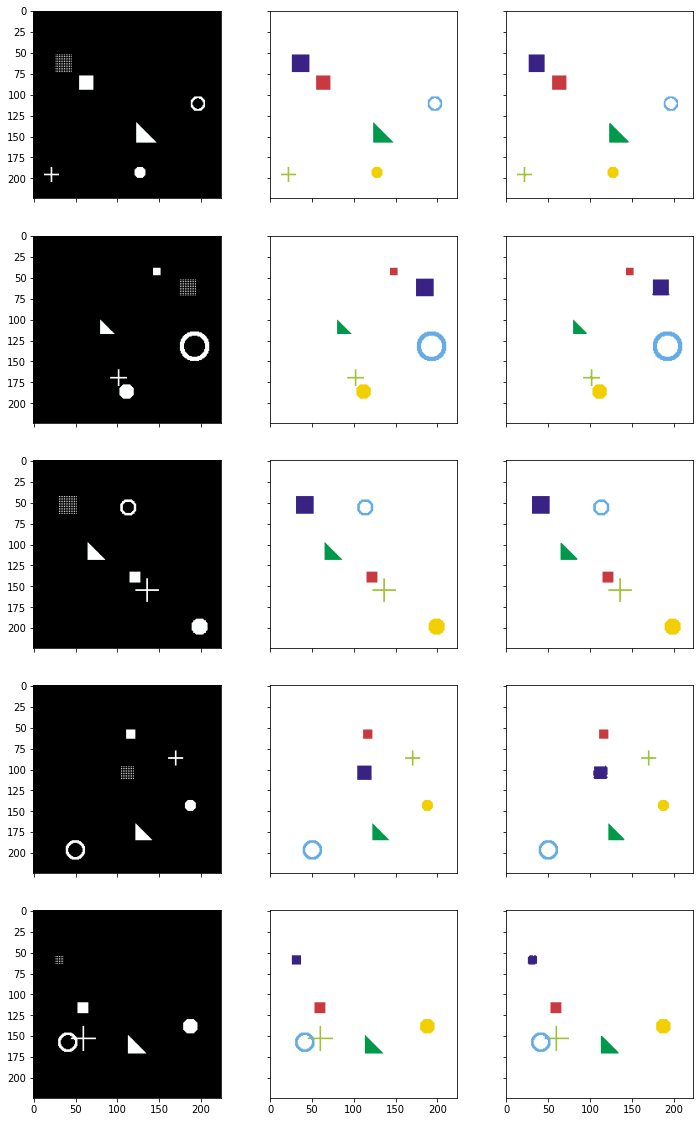

In [17]:
# import segmentation_models_pytorch as smp
# from segmentation.smp_effb4 import SMP_DIY
# from segmentation.timm_unetb4 import UnetB4
from segmentation.timm_srm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer 
# from segmentation.timm_efficientnet import EfficientNet
from sim_dataset import SimDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import simulation_helper
from torchvision import transforms

device = 'cuda'
encoder = SRM_Classifer()
model = UnetPP(encoder, num_classes=6, sampling='nearest', layer='end')
model = nn.DataParallel(model)
model.load_state_dict(torch.load('weights/simulationUnetPP_[21|04_21|52|04].h5'))
model.to(device)
model.eval()   # Set model to the evaluation mode

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
# Create another simulation dataset for test
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image'].to(device)
labels = data['mask'].to(device)
elas = data['ela'].to(device)


# Predict
pred = model(inputs, elas)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [simulation_helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [simulation_helper.masks_to_colorimg(x) for x in pred]

simulation_helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [13]:
from collections import OrderedDict
ld = torch.load('best_weights/CASIA_64_ELA.h5')
newdict = OrderedDict()
for x in ld.keys():
    if 'base_model' in x:
        z = x.replace('.base_model','')
        newdict[z] = ld[x]
    else:
        newdict[x] = ld[x]

Dice Loss:0.09562963247299194
Dice:0.9043703675270081, IOU:0.8254343867301941, Label:tensor([[0.8948]])


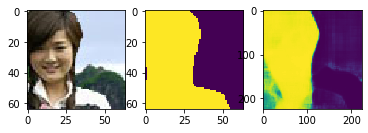

Dice Loss:0.535085916519165
Dice:0.4649140536785126, IOU:0.3028586506843567, Label:tensor([[0.8976]])


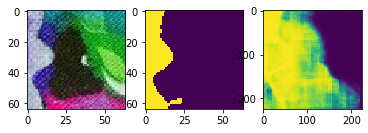

Dice Loss:0.02807760238647461
Dice:0.9719223976135254, IOU:0.9453784823417664, Label:tensor([[0.9058]])


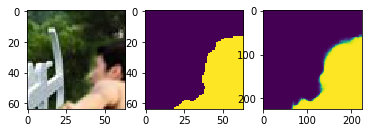

Dice Loss:0.191489577293396
Dice:0.808510422706604, IOU:0.6785711646080017, Label:tensor([[0.9010]])


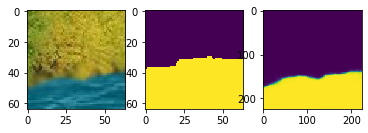

Dice Loss:0.0478367805480957
Dice:0.9521632194519043, IOU:0.9086941480636597, Label:tensor([[0.8936]])


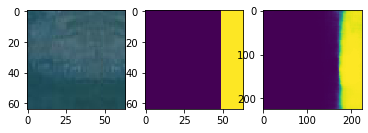

Dice Loss:0.3708534836769104
Dice:0.6291465163230896, IOU:0.4589451551437378, Label:tensor([[0.8816]])


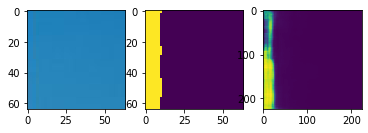

Dice Loss:0.16058605909347534
Dice:0.8394139409065247, IOU:0.7232673168182373, Label:tensor([[0.8668]])


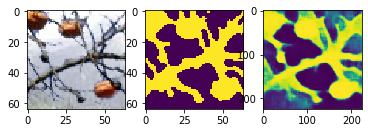

Dice Loss:0.009598791599273682
Dice:0.9904012084007263, IOU:0.9809849262237549, Label:tensor([[0.8979]])


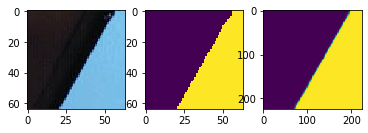

Dice Loss:0.012291967868804932
Dice:0.9877080321311951, IOU:0.9757145643234253, Label:tensor([[0.8984]])


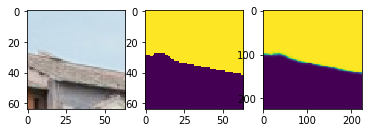

Dice Loss:0.047695934772491455
Dice:0.9523040652275085, IOU:0.9089508056640625, Label:tensor([[0.9021]])


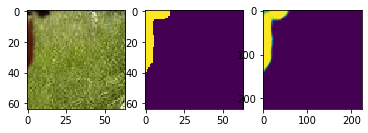

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.6628]])


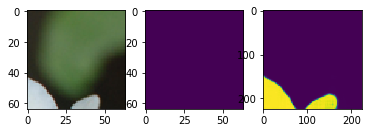

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1002]])


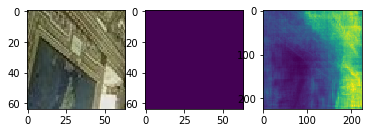

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0965]])


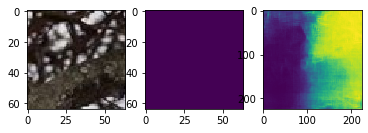

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0975]])


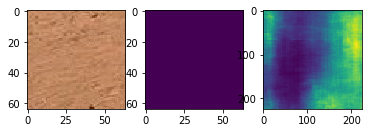

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1007]])


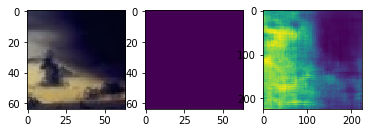

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1010]])


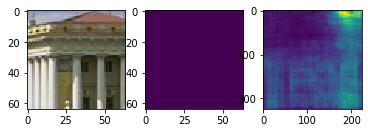

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.1001]])


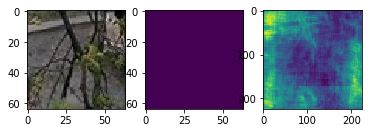

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0943]])


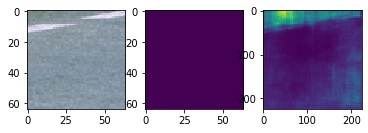

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0982]])


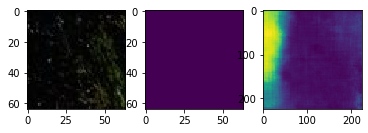

Dice Loss:0.0
Dice:0.0, IOU:0.0, Label:tensor([[0.0970]])


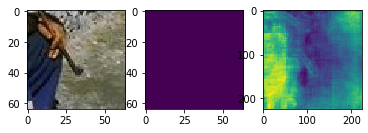

Total Dice:0.0, Total IOU:0.0
Best Dice: -1, Count = 0.0, IDX : 0
Best IOU: -1, Count = 0.0, IDX : 0
Total Dice2:0.0, Total IOU2:0.0


In [26]:
from pytorch_toolbelt import losses
from utils import *
import seg_metrics

root_dir = 'Image_Manipulation_Dataset/CASIA_2.0/image_patch_64'
for row in data:
    image_name, image_patch, mask_patch, label, fold, ela = row

    image_path = os.path.join(root_dir, image_name, image_patch)
    ela_path = os.path.join(root_dir, image_name, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1]))
    else:
        mask_path = os.path.join(root_dir, image_name, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    trans = valid_aug(image=image, mask=mask_image, ela=ela_image)
    tensor = trans["image"].unsqueeze(0).cuda()
    mask_tensor = trans["mask"].unsqueeze(0).cuda()
    ela_tensor = trans["ela"].unsqueeze(0).cuda()

    dice_tot = AverageMeter()
    jaccard_tot = AverageMeter()
    preds = []
    targets = []
    labels = []
    with torch.no_grad():
        out_label, _ = classifier(tensor, ela_tensor)
        out_label = F.logsigmoid(out_label.cpu()).exp()

        out_mask = localizer(tensor, ela_tensor)
        out_mask = F.logsigmoid(out_mask.cpu()).exp()
        mask_tensor = mask_tensor.cpu()

        dice = losses.functional.soft_dice_score(out_mask, mask_tensor)
        dice_tot.update(dice)
        jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor)
        jaccard_tot.update(jaccard)

        preds.append(out_mask)
        targets.append(mask_tensor)
        labels.append(out_label)

    loss = losses.DiceLoss(mode='binary', log_loss=False, from_logits=False)
    dice_loss = loss(out_mask, mask_tensor)
    print(f"Dice Loss:{dice_loss}")
    print(f"Dice:{dice}, IOU:{jaccard}, Label:{out_label}")
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)

    plt.subplot(132)
    plt.imshow(mask_image)

    plt.subplot(133)
    plt.imshow(image2np(out_mask.squeeze(0)))
    plt.show()

print(f"Total Dice:{dice_tot.avg}, Total IOU:{jaccard_tot.avg}")
dice_tot2, best_dice = seg_metrics.dice_coeff(preds, targets)  
jaccard_tot2, best_iou = seg_metrics.jaccard_coeff(preds, targets) 
print(f"Total Dice2:{dice_tot2.item()}, Total IOU2:{jaccard_tot2.item()}")

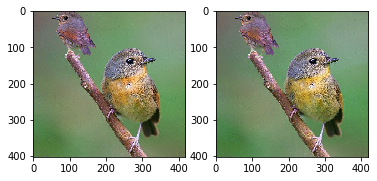

In [25]:
import imgaug.augmenters as iaa
aug = iaa.AddToHue(-250)

img = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_ani10201_ani10200_12412.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = aug.augment_image(image=img)

plt.figure(1)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(new_img)

plt.show()

In [13]:
import albumentations
import albumentations.pytorch

image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ela = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/ela_1.png')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)

mask = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1_gt.png', cv2.IMREAD_GRAYSCALE)
# mask = np.expand_dims(mask, 2)

# mask_tensor = torch.from_numpy(mask.transpose(2, 0, 1))
# print(mask_tensor.shape, mask_tensor.type())

# plt.figure(figsize=(10,20))
# plt.subplot(1,3,1)
# plt.imshow(image)
# plt.subplot(1,3,2)
# plt.imshow(ela)
# plt.subplot(1,3,3)
# plt.imshow(mask)
# plt.show()

image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
mask = augmentations.geometric.functional.resize(mask, 256, 256, cv2.INTER_AREA)
ela = augmentations.geometric.functional.resize(ela, 256, 256, cv2.INTER_AREA)

print(image.shape, image.dtype)
print(ela.shape, ela.dtype)
print(mask.shape, mask.dtype)

(256, 256, 3) uint8
(256, 256, 3) uint8
(256, 256) uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([256, 256]) torch.FloatTensor


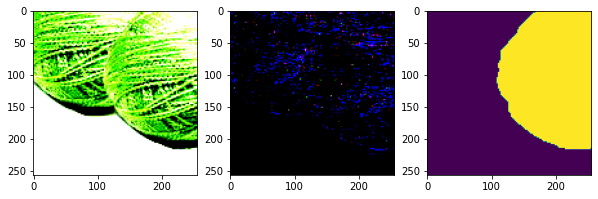

In [5]:
normalize = {
    "mean": [0.4535, 0.4286, 0.4178],
    "std": [0.2673, 0.2550, 0.2947],
}

transforms_normalize = albumentations.Compose(
    [
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)

data = transforms_normalize(image=image, mask=mask, ela=ela)
aug_image = data["image"]
aug_mask = data["mask"] / 255.0
aug_ela = data["ela"]

print(aug_image.shape, aug_image.type())
print(aug_ela.shape, aug_ela.type())
print(aug_mask.shape, aug_mask.type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(aug_image.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(aug_ela.permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(aug_mask)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


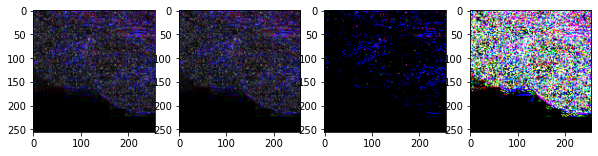

In [29]:
# plt.figure(figsize=(10,20))
# plt.subplot(1,3,1)
# plt.imshow(image)
# plt.subplot(1,3,2)
# plt.imshow(tensor_image.permute(1,2,0))
# plt.subplot(1,3,3)
# plt.imshow(normal_image.permute(1,2,0))
# plt.show()

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(ela)
plt.subplot(1,4,2)
plt.imshow(tensor_ela.permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(normal_ela_old.permute(1,2,0))
plt.subplot(1,4,4)
plt.imshow(normal_ela_new.permute(1,2,0))
plt.show()

In [3]:
import dataset
reload(dataset)
from dataset import DATASET
import albumentations.pytorch

df = pd.read_csv(f"combo_all_FULL.csv").sample(frac=1.0).reset_index(drop=True)

normalize = {
    "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
    "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
}
train_geo_aug = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.RandomRotate90(p=0.1),
        albumentations.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=35, p=0.25),
    ],
    additional_targets={'ela':'image'}
)
transforms_normalize = albumentations.Compose(
    [
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    additional_targets={'ela':'image'}
)
train_dataset = DATASET(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=1,
    patch_size="FULL",
    resize=256,
    transforms_normalize=transforms_normalize,
    imgaug_augment=None,
    geo_augment=train_geo_aug
)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=16, pin_memory=True, drop_last=False)

real:10511, fakes:8173, mode = train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
dict_keys(['image', 'image_path', 'label', 'mask', 'ela'])
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor


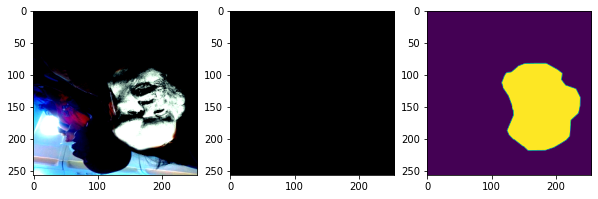

In [19]:
data = train_dataset[1112]
print(data.keys())
print(data['image'].shape, data['image'].type())
print(data['mask'].shape, data['mask'].type())
print(data['ela'].shape, data['ela'].type())

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(data['image'].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(data['ela'].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(data['mask'])
plt.show()

## DICE Testing

In [117]:
import torch
import numpy as np 

x = [[0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0]]

y1 = [[0,0,0,0,0,0,0,0],
      [0,0.75,0.89,0.95,0,0,0,0],
      [0,0.66,0.92,0.93,0,0,0,0],
      [0,0.75,0.77,0.91,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0]]

y2 = [[0,0,0,0,0,0,0,0],
      [0,0.75,0.89,0.95,0,0,0,0],
      [0,0.66,0.92,0.93,0,0,0,0],
      [0,0.75,0.77,0.16,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0.01,0.2,0],
      [0,0,0,0,0,0.15,0.11,0]]

gt = torch.tensor(x).unsqueeze(0).float()
out1 = torch.tensor(y1).unsqueeze(0).float()
out2 = torch.tensor(y2).unsqueeze(0).float()

label = torch.stack([gt, gt])
pred = torch.stack([out1, out2])

In [124]:
"a/b/c/d/e".split('/', 2)

['a', 'b', 'c/d/e']

In [118]:
import seg_metrics
reload(seg_metrics)
from seg_metrics import get_fpr

get_fpr(pred, label)

(0.1328125, (0.125, 1), (0.140625, 0))

In [22]:
# from pytorch_toolbelt.losses import dice
# reload(dice)

from toolbelt_DiceLoss import DiceLoss

dice = DiceLoss(mode='binary', log_loss=True, smooth=1e-7, from_logits=False)
dice(pred.float().cuda(), label.float().cuda())

-> tensor([2.5000e-08], device='cuda:0')


tensor(16.1181, device='cuda:0')

In [10]:
from losses import DiceLoss, ImanipLoss
from torch import nn
from torch.nn.modules.loss import _Loss
class ImanipLoss(_Loss):

    def __init__(self, bce: nn.Module, dice: nn.Module):
        super().__init__()
        self.bce = bce
        self.dice = dice

    def forward(self, pred_mask, gt, label_tensor, target_label):
        b = self.bce(label_tensor, target_label)
        d = self.dice(pred_mask, gt)
        print("bce", b)
        print("dice", d)
        return  b*d 

def get_lossfn():
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss(mode='binary', log_loss=True, smooth=1e-7, from_logits=False)
    criterion = ImanipLoss(bce, dice)
    return criterion

loss = get_lossfn()

In [13]:
bc = loss(pred.float().cuda(), label.float().cuda(), torch.from_numpy(np.array([-1.38])), torch.from_numpy(np.array([0.0])))
bc

bce tensor(0.2244, dtype=torch.float64)
dice tensor(16.1181, device='cuda:0')


tensor(3.6170, device='cuda:0', dtype=torch.float64)

In [4]:
from pytorch_toolbelt import losses

losses.functional.soft_dice_score(out2, gt, smooth=1e-7).item()

0.6666666865348816

In [10]:
import seg_metrics
reload(seg_metrics)

print(seg_metrics.get_avg_batch_dice(pred, label))
print(seg_metrics.get_avg_batch_jaccard(pred, label))

(0.5733333379030228, (0.6666666865348816, 1), (0.47999998927116394, 0))
(0.40789473056793213, (0.5, 1), (0.31578946113586426, 0))


In [7]:
scores = seg_metrics.DiceMeter()
scores.update(label, pred)
seg_metrics.epoch_score_log('TRAIN', scores)

TRAIN -> dice: 0.5733 | dice_neg: nan | dice_pos: 0.5733 | IoU: 0.4079
/home/msi/sowmen_workspace/imanip_main/seg_metrics.py:153: RuntimeWarning: Mean of empty slice
  dice_neg = np.nanmean(self.dice_neg_scores)


(0.5733333, nan, 0.5733333, 0.40789473684210525)

## ---------------------

In [7]:
from segmentation.timm_srm_unetpp import UnetPP
from segmentation.merged_net import SRM_Classifer 
from pytorch_toolbelt import losses
import seg_metrics
reload(seg_metrics)

device = 'cuda'

encoder = SRM_Classifer(encoder_checkpoint='weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5', freeze_encoder=False)
model = UnetPP(encoder, num_classes=1, sampling='nearest', layer='end')
model.to(device)
model = nn.DataParallel(model)

# bce = nn.BCEWithLogitsLoss()
criterion = losses.DiceLoss(mode='binary', log_loss=True, smooth=1e-7)

targets = []
outputs = []

for batch in train_loader:
    images = batch["image"].to(device)
    elas = batch["ela"].to(device)
    gt = batch["mask"].to(device).unsqueeze(1)

    print("Image:", images.shape, images.type(), "Grad :", images.requires_grad)
    print("GT:", gt.shape, gt.type(), "Grad :", gt.requires_grad)
    print("ELA:", elas.shape, elas.type(), "Grad :", elas.requires_grad)

    out_mask = model(images, elas)

    print("Output:", out_mask.shape, out_mask.type(), "Grad :", out_mask.requires_grad)

    loss_segmentation = criterion(out_mask, gt)
    
    print("Loss:", loss_segmentation)

    with torch.no_grad():
        out_mask = torch.sigmoid(out_mask.cpu().detach())
        gt = gt.cpu().detach()

        print("Output Detach:", out_mask.shape, out_mask.type(), "Grad :", out_mask.requires_grad)
        print("GT Detach:", gt.shape, gt.type(), "Grad :", gt.requires_grad)

        list_out = list(out_mask)
        print("Len:", len(list_out))
        for x in list_out:
            print("Output List:", x.shape, x.type(), "Grad :", x.requires_grad)
        
    #     targets.extend(list(gt))
    #     outputs.extend(list(out_mask))
    break

# print("~~~~~~~~~~~~~~~~~~~~~~~~~")
# dice, _ = seg_metrics.dice_coeff(outputs, targets) 
# jaccard, _ = seg_metrics.jaccard_coeff(outputs, targets)  
# print("~~~~~~~~~~~~~~~~~~~~~~~~~")

# print(dice)
# print(jaccard)

--------- Loaded Checkpoint: weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5 ----------
<All keys matched successfully>
----- Loaded Changed Dice -----
Image: torch.Size([6, 3, 256, 256]) torch.cuda.FloatTensor Grad : False
GT: torch.Size([6, 1, 256, 256]) torch.cuda.FloatTensor Grad : False
ELA: torch.Size([6, 3, 256, 256]) torch.cuda.FloatTensor Grad : False
Output: torch.Size([6, 1, 256, 256]) torch.cuda.FloatTensor Grad : True
Loss: tensor(1.1703, device='cuda:0', grad_fn=<MeanBackward0>)
Output Detach: torch.Size([6, 1, 256, 256]) torch.FloatTensor Grad : False
GT Detach: torch.Size([6, 1, 256, 256]) torch.FloatTensor Grad : False
Len: 6
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.FloatTensor Grad : False
Output List: torch.Size([1, 256, 256]) torch.Flo

In [10]:
import segmentation.merged_net
reload(segmentation.merged_net)

from segmentation.merged_net import SRM_Classifer
from segmentation.timm_srm_unetpp import UnetPP

encoder = SRM_Classifer(encoder_checkpoint='weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5', freeze_encoder=True)
model = UnetPP(encoder, num_classes=1, sampling="nearest", layer='end')

out_labels = model(data['image'].unsqueeze(0), data['ela'].unsqueeze(0))
print(out_labels.shape)

--------- SRM Frozen -----------
--------- Loaded Checkpoint: weights/Changed classifier+COMBO_ALL_FULLSRM+ELA_[08|03_21|22|09].h5 ----------
<All keys matched successfully>
torch.Size([1, 1, 256, 256])


In [89]:
from pytorch_toolbelt import losses
import seg_metrics

dice = losses.DiceLoss(mode='binary')

mask = cv2.imread('Image_Manipulation_Dataset/COVERAGE/coverage_full/mask/1forged.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (8, 8), cv2.INTER_AREA)


mask_tensor = torch.from_numpy(mask / 255.0)
print(mask_tensor.type())

# input = mask_tensor.unsqueeze(0).unsqueeze(0)
# gt = mask_tensor.unsqueeze(0)

# print(mask_tensor.shape, mask_tensor.type())
# print(input.shape, input.type())
# print(gt.shape, gt.type())

# # print(dice(input, gt))
# # print(seg_metrics.dice_score(mask_tensor, mask_tensor))
print(soft_dice_score(mask_tensor, mask_tensor))

torch.DoubleTensor
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor(9., dtype=torch.float64) tensor(18., dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [87]:
normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.geometric.resize.Resize(18, 18, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)

image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ela = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/ela_1.png')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)

mask = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/image_patch_128/Tp_S_NNN_S_N_ani20014_ani20014_02057/1_gt.png', cv2.IMREAD_GRAYSCALE)

trans = valid_aug(image=image, mask=mask, ela=ela)
tensor = trans["image"].unsqueeze(0).cuda()
mask_tensor = trans["mask"].unsqueeze(0).cuda()
ela_tensor = trans["ela"].unsqueeze(0).cuda()

print(tensor.size(), tensor.type())
print(mask_tensor.size(), mask_tensor.type())
print(ela_tensor.size(), ela_tensor.type())

print(mask_tensor)

print(losses.functional.soft_dice_score(mask_tensor, mask_tensor))

torch.Size([1, 3, 18, 18]) torch.cuda.FloatTensor
torch.Size([1, 1, 18, 18]) torch.cuda.FloatTensor
torch.Size([1, 3, 18, 18]) torch.cuda.FloatTensor
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           

## CALCULATE LR FOR CyclicScheduler

In [3]:
import math 

device = 'cuda:1'
# Create the model
from segmentation.merged_net import SRM_Classifer
model = SRM_Classifer().to(device)

start_lr = 1e-7
end_lr = 0.01
lr_find_epochs = 3

optimizer = torch.optim.Adam(model.parameters(), start_lr)
criterion = nn.BCEWithLogitsLoss()

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( train_loader )))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Make lists to capture the logs

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for batch in tqdm(train_loader):
    
    # Send to device
    images = batch["image"].to(device)
    elas = batch["ela"].to(device)
    target_labels = batch["label"].to(device)
    
    # Training mode and zero gradients
    model.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs, _ = model(images, elas)
    loss = criterion(outputs, target_labels.view(-1, 1).type_as(outputs))

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

100%|██████████| 2342/2342 [15:48<00:00,  2.47it/s]


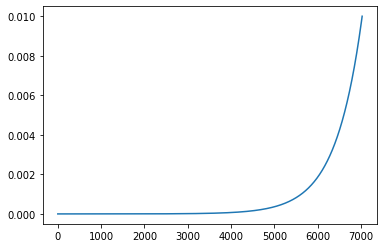

In [5]:
plt.plot(lr_find_lr)
plt.show()

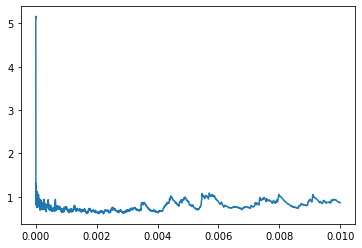

In [7]:
plt.plot(lr_find_lr, lr_find_loss)
plt.show()

In [20]:
from utils import topk_accuracy
from sklearn import metrics
from torchmetrics import MetricCollection, Accuracy, F1

image = inp['image']
ela = inp['ela']
# label = inp['label']
label = torch.tensor([33, 267, 100, 262, 95, 245, 232, 109])
print(image.shape, image.type())
print(ela.shape, ela.type())
print('label->', label.shape, label.type(), label)

out, _ = model(image, ela)
print("output->", out.shape, out.type())
pred = torch.argmax(out, dim=1)
print('argmax', pred.shape, pred)
sk_acc = metrics.accuracy_score(label, pred)
print(sk_acc)

top = topk_accuracy(out.cpu().detach(), label, topk=(1,5))
print(top)

met = col(torch.softmax(out.cpu().detach(), dim=-1), label)
print(met)

torch.Size([8, 3, 256, 256]) torch.FloatTensor
torch.Size([8, 3, 256, 256]) torch.FloatTensor
label-> torch.Size([8]) torch.LongTensor tensor([ 33, 267, 100, 262,  95, 245, 232, 109])
output-> torch.Size([8, 312]) torch.FloatTensor
argmax torch.Size([8]) tensor([292, 267,  67, 262,  95, 149, 232, 109])
0.625
[tensor([0.6250]), tensor([0.6250])]
{'Accuracy': tensor(0.6250), 'F1': tensor(0.6250)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Image_Manipulation_Dataset/FODB/extracted_images/D04_0022_JPEG_Double_Compression_160.jpg 98 JPEG_Double_CompressionQ = 61, 91
torch.Size([3, 256, 256]) torch.FloatTensor
torch.Size([3, 256, 256]) torch.FloatTensor


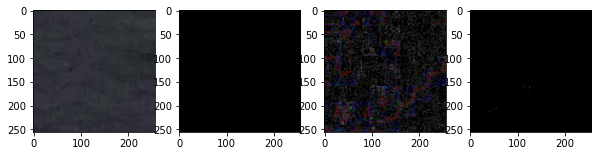

In [42]:
ret = valid_dataset[50]

image = ret['image']
ela = ret['ela']
label = ret['label']

print(ret['image_path'], label, ret['type'])
print(image.shape, image.type())
print(ela.shape, ela.type())

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(ret['raw_image'])
plt.subplot(1,4,2)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(ret['raw_ela'])
plt.subplot(1,4,4)
plt.imshow(ela.permute(1,2,0))
plt.show()

In [19]:
with open('Image_Manipulation_Dataset/VISION/VISION_images.txt', 'r') as f:
    lines = f.read().splitlines()
len(lines)

11732

In [32]:
import requests

def dl(url):
    filename = url.split('/')[-1]
    dir = url.split('/', 5)[-1].rsplit('/', 1)[0]
    folder = os.path.join('Image_Manipulation_Dataset/VISION', dir)
    os.makedirs(folder, exist_ok=True)
    # print(filename, dir)
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(folder, filename), 'wb').write(r.content)
    # break


In [33]:
from functools import partial
from glob import glob
from multiprocessing.pool import Pool

with Pool(processes=os.cpu_count()) as p:
    with tqdm(total=len(lines)) as pbar:
        for v in p.imap_unordered(
            partial(
                dl
            ),
            lines,
        ):
            pbar.update()

100%|██████████| 11732/11732 [1:18:42<00:00,  2.48it/s]


In [2]:
from utils import get_dataframe

# casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
# imd_full = get_dataframe('dataset_csv/imd_FULL.csv', folds=None)
# cmfd_full = get_dataframe('dataset_csv/cmfd_FULL.csv', folds=-1)
# nist_full = get_dataframe('dataset_csv/nist16_FULL.csv', folds=None)
# coverage_full = get_dataframe('dataset_csv/coverage_FULL.csv', folds=None)

# nist_extend = get_dataframe('nist_extend.csv', folds=12)
# coverage_extend = get_dataframe('coverage_extend.csv', folds=12)
# defacto_cp = get_dataframe('dataset_csv/defacto_copy_move.csv', folds=-1)
# defacto_inpaint = get_dataframe('dataset_csv/defacto_inpainting.csv', folds=-1)
# defacto_s1 = get_dataframe('dataset_csv/defacto_splicing1.csv', folds=-1)
# defacto_s2 = get_dataframe('dataset_csv/defacto_splicing2.csv', folds=-1)
# defacto_s3 = get_dataframe('dataset_csv/defacto_splicing3.csv', folds=-1)


# df_full = pd.concat([casia_full, imd_full, cmfd_full, nist_full, coverage_full])#, \
#                 nist_extend, coverage_extend, defacto_cp, \
#                     defacto_inpaint, defacto_s1, defacto_s2, defacto_s3])
df_full = get_dataframe('dataset_csv/casia_128.csv', folds=None)
# df_full.insert(0, 'image', '')
df_full = df_full[df_full['label'] == 1]

rows = df_full.values

In [4]:
print(len(rows))

15436


In [7]:
def _filter_mask(data, count):
    temp_data = []

    removed_count, lines = 0 , []
    # if os.path.exists("filtermask50.txt"):
    #     with open("filtermask50.txt", "r") as fp: lines = fp.read().splitlines()

    pbar = tqdm(data, desc="Filtering empty mask")
    for row in pbar:
        image_name, _, mask_patch, _, _, _, root_dir = row

        if mask_patch != '':
            mask_path = os.path.join('/media/crimson/easystore/image_manipulation/Image_Manipulation_Dataset', root_dir, image_name, mask_patch)
            if(not os.path.exists(mask_path)): print(f"Mask Not Found : {mask_path}")
            
            flag = 0
            if len(lines) > 0:
                if mask_path in lines: flag = 1
            else:
                mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if('NIST' in root_dir): mask_image = 255 - mask_image

                mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
                if(np.count_nonzero(mask_image) < count): flag = 1
            
            if flag:
                removed_count += 1
                pbar.set_postfix({'removed': removed_count})
                continue
            
        temp_data.append(row)
            
    return temp_data
nonzero = _filter_mask(rows, 100)

Filtering empty mask: 100%|██████████| 15436/15436 [02:21<00:00, 109.41it/s, removed=187]


In [9]:
nonzero2 = []

In [10]:
from torchvision import transforms
transTensor = transforms.ToTensor()

for row in tqdm(rows):
    image_name, image_patch, mask_patch, label, _, ela, root_dir = row

    mask_path = os.path.join('/media/crimson/easystore/image_manipulation/Image_Manipulation_Dataset', root_dir, image_name, mask_patch)

    if(not os.path.exists(mask_path)): print(f"Mask Not Found : {mask_path}")
    
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if('NIST' in root_dir):
        mask_image = 255 - mask_image

    mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
    tensor_mask = transTensor(mask_image)

    if(np.count_nonzero(tensor_mask.numpy().ravel() >= 0.5) < 100):
        nonzero2.append(mask_path)
        # print(mask_path)

100%|██████████| 15436/15436 [00:14<00:00, 1098.32it/s]


In [11]:
len(nonzero2)

187

In [12]:
with open("filtermask100.txt", 'a') as file_handler:
    for item in nonzero2:
        file_handler.write("{}\n".format(item))

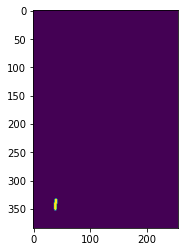

In [13]:
mask = cv2.imread('I:/image_manipulation/Image_Manipulation_Dataset/CASIA_2.0/Gt/Tp_S_NNN_S_B_art00070_art00070_01241_gt.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
plt.show()

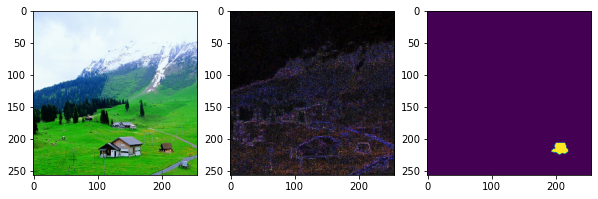

In [46]:
ROOT = 'I:/image_manipulation/'

image = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256))

ela = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_NNN_S_N_nat20015_nat20018_01519_ela.jpg')
ela = cv2.cvtColor(ela, cv2.COLOR_BGR2RGB)
ela = cv2.resize(ela, (256,256))

mask = cv2.imread(ROOT+'Image_Manipulation_Dataset/CASIA_2.0/Gt/Tp_D_NNN_S_N_nat20015_nat20018_01519_gt.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(ela)
plt.subplot(1,3,3)
plt.imshow(mask)
plt.show()

# image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
# mask = augmentations.geometric.functional.resize(mask, 256, 256, cv2.INTER_AREA)
# ela = augmentations.geometric.functional.resize(ela, 256, 256, cv2.INTER_AREA)

# print(image.shape, image.dtype)
# print(ela.shape, ela.dtype)
# print(mask.shape, mask.dtype)

In [18]:
from dataset import DATASET
from utils import get_dataframe, get_train_transforms


casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
casia_full.insert(0, 'image', '')
train_imgaug, train_geo_aug = get_train_transforms()

train_dataset = DATASET(
    dataframe=casia_full,
    mode="train",
    val_fold=0,
    test_fold=1,
    segment=False,
    transforms_normalize=None,
    imgaug_augment=train_imgaug,
    geo_augment=train_geo_aug,
    supcon=True,
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

Filtering empty mask: 100%|████████████████████| 10073/10073 [00:01<00:00, 9625.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0.9


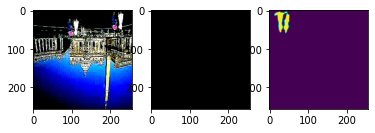

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


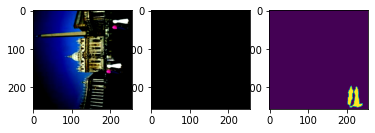

In [22]:
print(train_dataset[15]['label'])
plt.figure()
plt.subplot(1,3,1)
plt.imshow(train_dataset[15]['image'][0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(train_dataset[15]['ela'][0].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(train_dataset[15]['mask'][0].permute(1,2,0))
plt.show()

plt.figure()
plt.subplot(1,3,1)
plt.imshow(train_dataset[15]['image'][1].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(train_dataset[15]['ela'][1].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(train_dataset[15]['mask'][1].permute(1,2,0))
plt.show()

In [25]:
for batch in train_loader:
    images = batch["image"]
    elas = batch["ela"]
    gt = batch["mask"]
    target_labels = batch["label"]

    print(images[0].shape)
    print(target_labels.shape)
    break

torch.Size([4, 3, 256, 256])
torch.Size([4])


In [3]:
import segmentation_models_pytorch as smp

encoder = smp.encoders.get_encoder('timm-efficientnet-b4')

In [5]:
print(encoder)

EfficientNetEncoder(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (con

In [9]:
features = encoder(torch.randn(1,3,256,256))
for f in features:
    print(f.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 48, 128, 128])
torch.Size([1, 32, 64, 64])
torch.Size([1, 56, 32, 32])
torch.Size([1, 160, 16, 16])
torch.Size([1, 448, 8, 8])


In [2]:
from dataset import DATASET
from utils import get_dataframe
from torch.utils.data import DataLoader

casia_full = get_dataframe('dataset_csv/casia_FULL.csv', folds=None)
casia_full.insert(0, 'image', '')

test_dataset = DATASET(
    dataframe=casia_full,
    mode="test",
    segment=False,
    val_fold=0,
    test_fold=1,
    transforms_normalize=None,
    equal_sample=True
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

Filtering empty mask: 100%|██████████| 1022/1022 [00:13<00:00, 73.70it/s]


torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256]) tensor([0.9000, 0.9000, 0.1000, 0.1000, 0.1000, 0.9000, 0.1000, 0.1000, 0.9000,
        0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
       dtype=torch.float64)
tensor([2, 3, 4, 6, 7, 9])
tensor([ 0,  1,  5,  8, 10, 11, 12, 13, 14, 15])
torch.Size([6, 1, 256, 256]) torch.Size([10, 1, 256, 256])


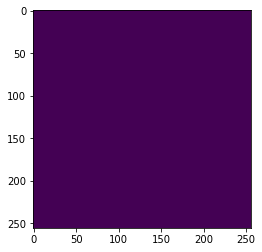

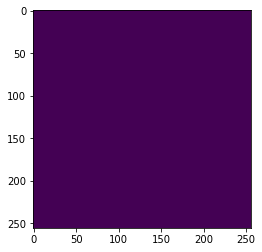

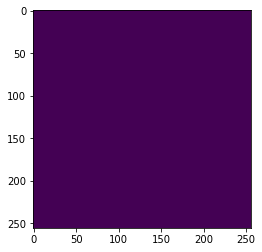

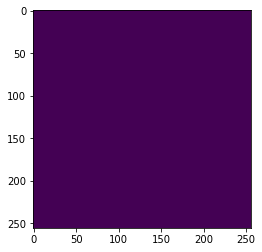

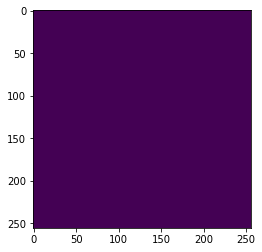

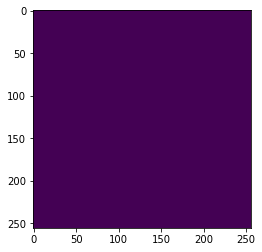

--------


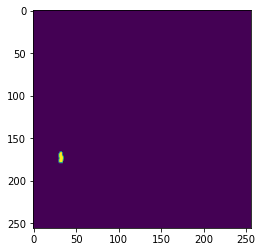

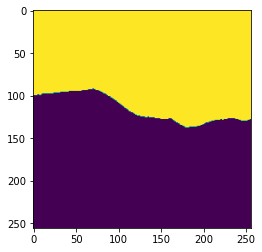

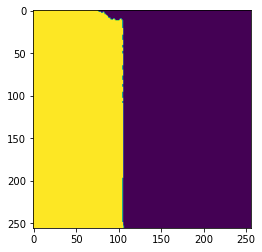

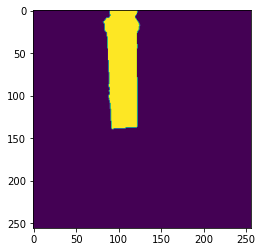

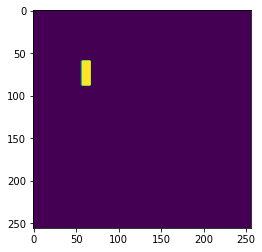

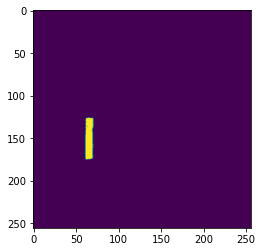

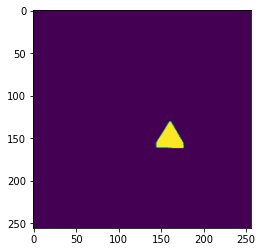

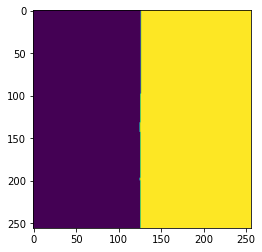

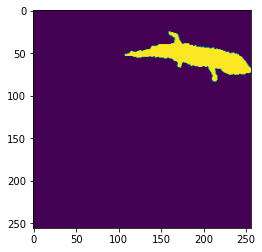

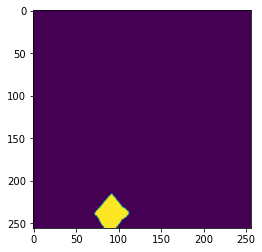

In [3]:
for data in test_loader:
    images = data["image"]
    elas = data["ela"]
    gt = data["mask"]
    target_labels = data["label"]
    print(images.shape, elas.shape, gt.shape, target_labels)
    
    real_indices = torch.where(target_labels < 0.5)[0]
    fake_indices = torch.where(target_labels > 0.5)[0]
    print(real_indices)
    print(fake_indices)
    real_images = gt[real_indices]
    fake_images = gt[fake_indices]
    print(real_images.shape, fake_images.shape)

    for im in real_images:
        plt.figure()
        plt.imshow(im.permute(1,2,0))
        plt.show()
    print("--------")
    for im in fake_images:
        plt.figure()
        plt.imshow(im.permute(1,2,0))
        plt.show()
    break 

In [16]:
from segmentation.smp_srm import SMP_SRM_UPP

upp = SMP_SRM_UPP()
decoder = upp.decoder
encoder = upp.encoder
# summary(encoder, [(1,3,256,256), (1,3,256,256)], device='cpu')
print(decoder)

encoder---> (448, 160, 56, 32, 48)
skip_channels---> [160, 56, 32, 48, 0]
depth/layer = 0/0 :  448 256 160
depth/layer = 0/1 :  256 128 112
depth/layer = 1/1 :  160 56 56
depth/layer = 0/2 :  128 64 96
depth/layer = 1/2 :  56 32 64
depth/layer = 2/2 :  56 32 32
depth/layer = 0/3 :  64 32 192
depth/layer = 1/3 :  32 48 144
depth/layer = 2/3 :  32 48 96
depth/layer = 3/3 :  32 48 48
UnetPlusPlusDecoder(
  (center): Identity()
  (blocks): ModuleDict(
    (x_0_0): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(608, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention1): Attention(
        (attention): SCSEModule(
          (cSE): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(608, 38, kernel_size=(1, 1), stride=(1, 1))
            (2): ReLU(inplace=True)
            (3): Con

In [3]:
decoder.in_channels

[448, 256, 128, 64, 32]